# 데이터 전처리 및 특성공학

## 데이터 특성공학

In [1]:
import sys
import warnings

!pip3 install xgboost

if "google.colab" in sys.modules:
    ## Colab에서 실행하는 경우 필요한 라이브러리를 미리 설치합니다.
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 293 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 9.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 4.7 MB 48.1 MB/s 
     |████████████████████████████████| 102 kB 43.7 MB/s 
     |████████████████████████████████| 696 kB 43.7 MB/s 
     |████████████████████████████████| 355 kB 46.4 MB/s 
     |████████████████████████████████| 296 kB 45.1 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0eea2640d152b35c80ea0e6fa0bfed3abebade7042f57809b1c3d91c5b2c46ab
  Stored in directory: /root/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996ac

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DCSS_All_Player.csv')

Win_per는 오차가 있고, object 타입이라서 Odds라는 특성으로 다시 만들어줍니다.


Last_game과 First_game간의 차이를 구한 뒤, 모두 초 단위로 바꿔서 Playtime이라는 새로운 특성을 만듭니다.

In [ ]:
target = 'Odds'
df = df.eval('Odds = Games_won / Games_Played')
df['Total_score'] = df['Total_score'].replace(',','',regex=True).astype(int)
df['Best_Score'] = df['Best_Score'].replace(',','',regex=True).astype(int)
df = df.eval('Avg_Score = Total_score / Games_Played')
df['Avg_Score'] = round(df['Avg_Score'], 0).astype(int)
df['First_game'] = pd.to_datetime(df['First_game'])
df['Last_game'] = pd.to_datetime(df['Last_game'])
a = (df['Last_game'] - df['First_game']).dt.days * 86400
b = (df['Last_game'] - df['First_game']).dt.seconds
df['Playtime'] = a+b
df['Avg_Playtime'] = df['Playtime'] / df['Games_Played']
df = df[df['Playtime'] > 0]
df = df[df['Avg_Playtime'] > 0]
df = df[df['Odds'] < 1.0]

In [5]:
target = 'Playtime'
df = df.eval('Odds = Games_won / Games_Played')
df['Total_score'] = df['Total_score'].replace(',','',regex=True).astype(int)
df['Best_Score'] = df['Best_Score'].replace(',','',regex=True).astype(int)
df = df.eval('Avg_Score = Total_score / Games_Played')
df['Avg_Score'] = round(df['Avg_Score'], 0).astype(int)
df['First_game'] = pd.to_datetime(df['First_game'])
df['Last_game'] = pd.to_datetime(df['Last_game'])
a = (df['Last_game'] - df['First_game']).dt.days * 86400
b = (df['Last_game'] - df['First_game']).dt.seconds
df['Playtime'] = a+b
df = df[df['Playtime'] > 0]
df = df[df['Odds'] < 1.0]
drop_cols = ['Win_per', 'Games_won', 'Average_Score','Player_name', 'First_game', 'Last_game', 'Best_XL']
df.drop(drop_cols, axis=1, inplace=True)

In [6]:
df['Playtime'] = np.log1p(df['Playtime'])

Games_won / Games_Played = Odds 라는 상관관계가 있기 때문에 Games_won은 drop해줍니다.

기존의 Win_per도 삭제. 필요없는 특성은 다 지워줍니다.

당연히 최대 레벨에 해당하는 Best_XL 또한 의미있는 지표가 아니며, Avg_Playtime이라는 평균 게임 시간을 새로 만들어줍니다.

Playtime이 0이거나 0보다 작을 경우 데이터 수집에서 오류라고 판단합니다.


승률이 100%인 경우, 오류거나 특출난 실력을 가졌다는 것이고 이는 예측하려는 방향성에서 벗어났기 때문에 삭제합니다.

In [ ]:
drop_cols = ['Win_per', 'Games_won', 'Average_Score','Player_name', 'First_game', 'Last_game', 'Games_Played', 'Best_XL']
df.drop(drop_cols, axis=1, inplace=True)

로그 변환이 필요한지 비교해봅니다.

In [ ]:
df.shape

(53865, 6)

In [ ]:
def change_log(col):
  df[col] = np.log1p(df[col])

change_log('Games_Played')
change_log('Playtime')
change_log('Avg_Score')
change_log('Best_Score')

## 데이터를 Train/Val/Test로 분리합니다.

In [8]:
def split_data(df):
    train = None
    val = None
    test = None

    train, test = train_test_split(df,test_size=0.20, 
                              random_state=42)
    
    train, val = train_test_split(train,test_size=0.25, 
                              random_state=42)

    return train, val, test

In [9]:
train, val, test = split_data(df.copy())

In [10]:
def divide_data(df):
    X = None
    y = None

    # YOUR CODE HERE
    X = df.drop(target, axis=1)
    y = df[target]
    # YOUR CODE ENDS HERE

    return X, y

In [11]:
X_train, y_train = divide_data(train)
X_val, y_val = divide_data(val)
X_test, y_test = divide_data(test)

## 기준 모델으로 MAE 구하기

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

predict = y_train.mean()
y_pred = [predict] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 데이터 MAE: {mae:.2f}')

rmse = mean_squared_error(y_train, y_pred, squared=False)
print("RMSE scores:", rmse)

r2 = r2_score(y_train, y_pred)
print("R2 scores:", r2)

훈련 에러: 0.02
RMSE scores: 0.06547118182509304
R2 scores: -2.220446049250313e-16


In [ ]:
y_pred = [predict] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'평가 데이터 MAE: {mae:.2f}')

rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE scores:", rmse)

r2 = r2_score(y_val, y_pred)
print("R2 scores:", r2)

테스트 에러: 0.02
RMSE scores: 0.06610259504544601
R2 scores: -1.5136087854639158e-05


target playtime

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

predict = y_train.mean()
y_pred = [predict] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

rmse = mean_squared_error(y_train, y_pred, squared=False)
print("RMSE scores:", rmse)

r2 = r2_score(y_train, y_pred)
print("R2 scores:", r2)

훈련 에러: 3.59
RMSE scores: 4.411845026999232
R2 scores: 0.0


In [ ]:
y_pred = [predict] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'테스트 에러: {mae:.2f}')

rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE scores:", rmse)

r2 = r2_score(y_val, y_pred)
print("R2 scores:", r2)

테스트 에러: 3.64
RMSE scores: 4.479054183289326
R2 scores: -0.0004778274983880948


## EDA 시각화

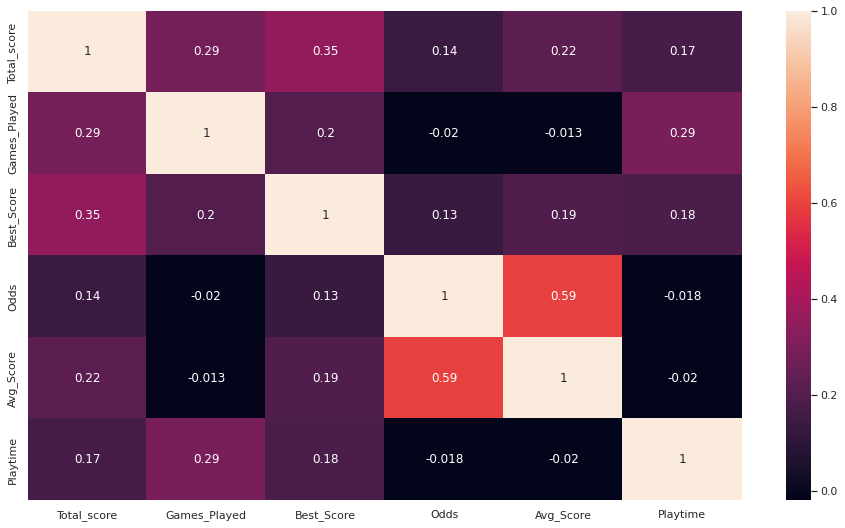

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.heatmap(df.corr(), annot=True)

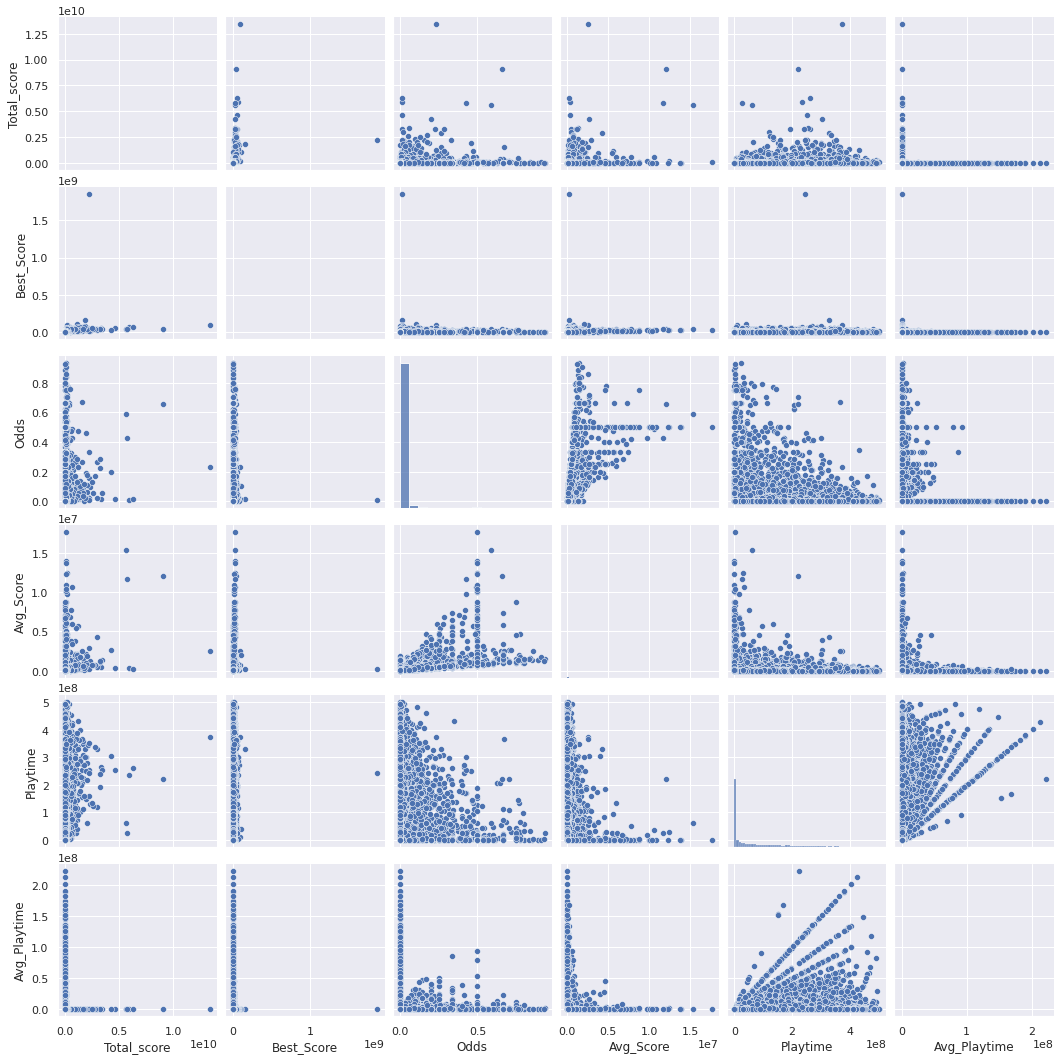

In [ ]:
import seaborn as sns

sns.pairplot(train)
plt.show()

EDA 결과

Total_score와 Best_Score에서 이상치가 발견된다.

이에 대한 처리를 생각해봐야 한다.

또한 Odds(승률)이 1.0 (100%)일 경우, 이는 우리가 예측하려는 일반적인 유저의 경우가 아니라 기존에 하던 사람이 새로운 계정을 만들었을 확률이 높다. 따라서 100% 승률은 전부 행을 삭제한다.

이후 각각 가설에 대해서 y축에 타겟, x축에 특성을 놓고 시각화를 진행하고 분석한 뒤 카이제곱 검정법을 시행해서 결과를 확인한다.

## 로그변환 과정

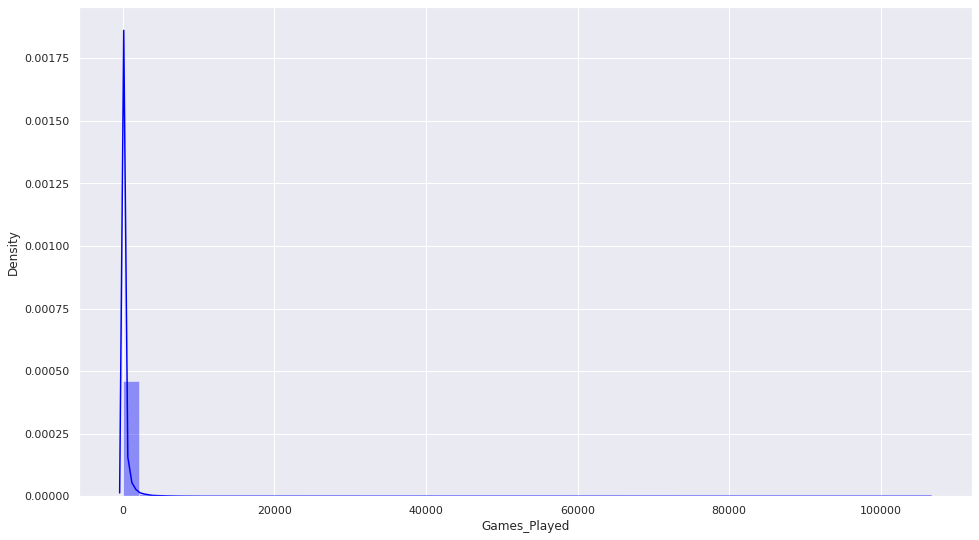

In [ ]:
sns.distplot(train['Games_Played'], color="blue")

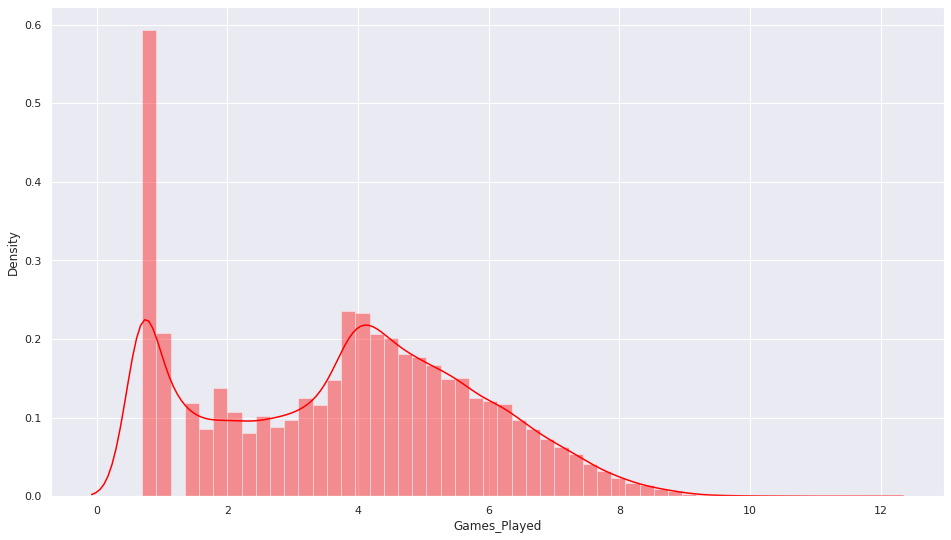

In [ ]:
train['Games_Played'] = np.log1p(train['Games_Played'])
sns.distplot(train['Games_Played'], color="red")

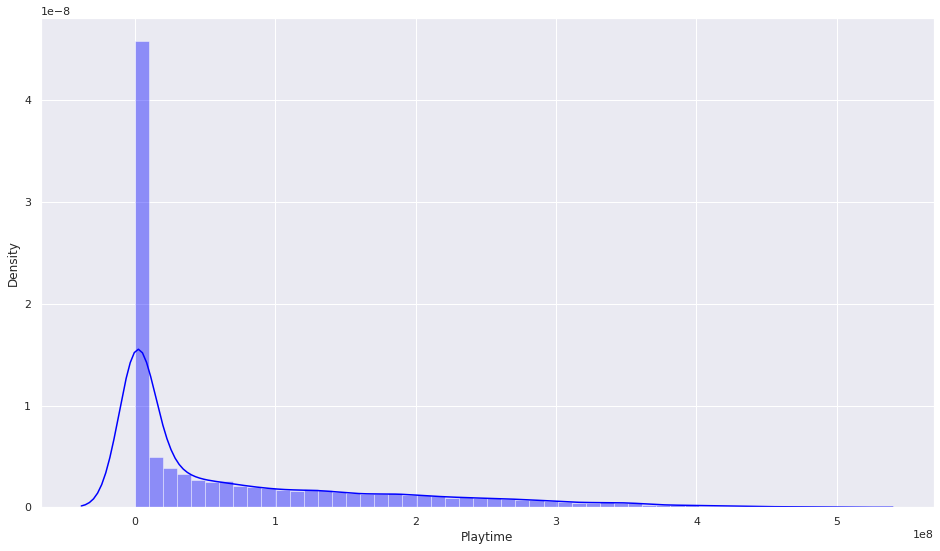

In [ ]:
sns.distplot(train['Playtime'], color="blue")

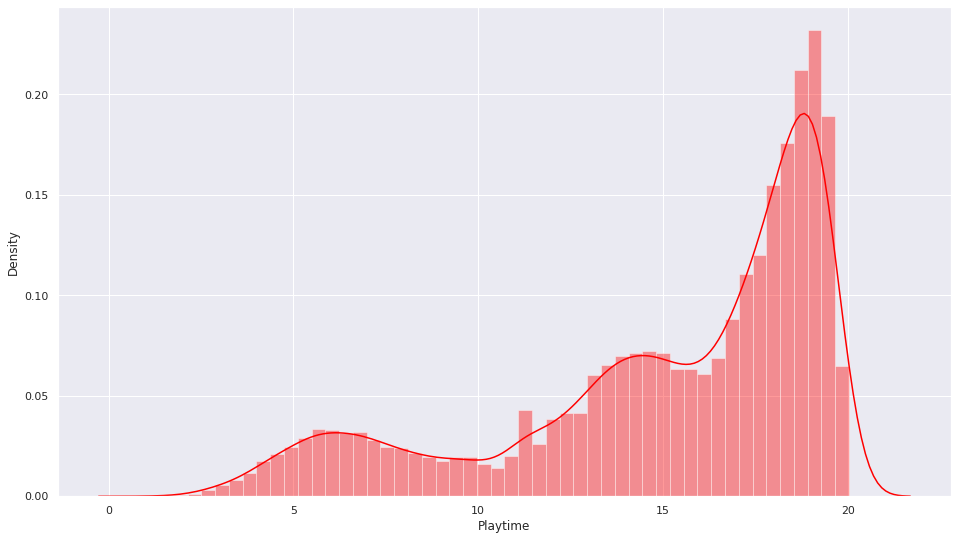

In [ ]:
train['Playtime'] = np.log1p(train['Playtime'])
sns.distplot(train['Playtime'], color="red")

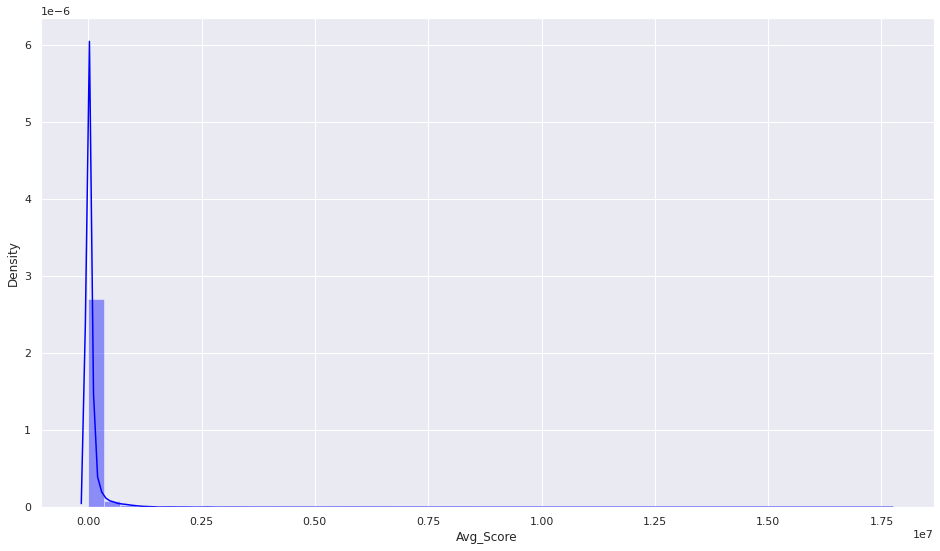

In [ ]:
sns.distplot(train['Avg_Score'], color="blue")

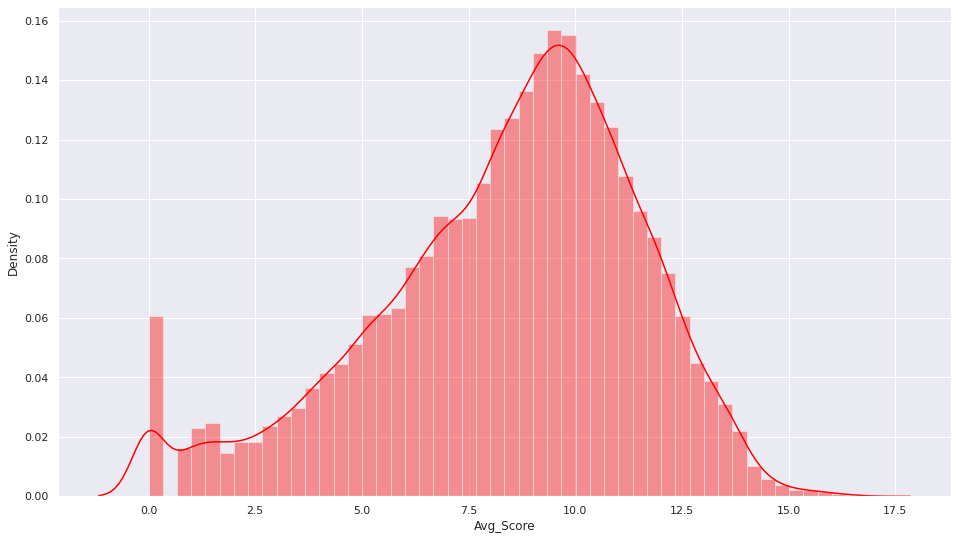

In [ ]:
train['Avg_Score'] = np.log1p(train['Avg_Score'])
sns.distplot(train['Avg_Score'], color="red")

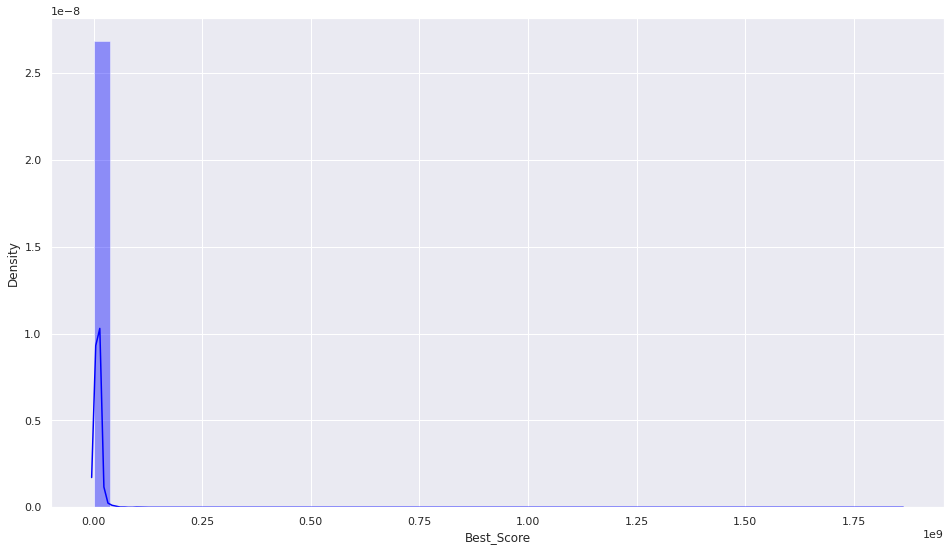

In [ ]:
sns.distplot(train['Best_Score'], color="blue")

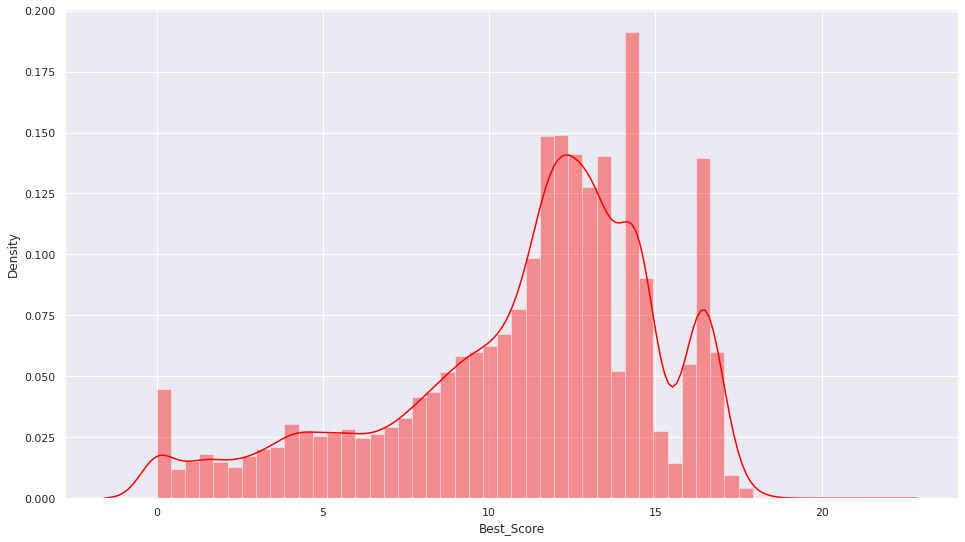

In [ ]:
train['Best_Score'] = np.log1p(train['Best_Score'])
sns.distplot(train['Best_Score'], color="red")

타겟인 Odds가 너무 불균형 데이터입니다.

그러나, 승률이 0%라는 것은 이상한 일이 아니고 아주 작은 수치를 예측해야 하기 때문에 이에 따라서 로그변환을 취해줄 이유가 없다고 판단합니다.



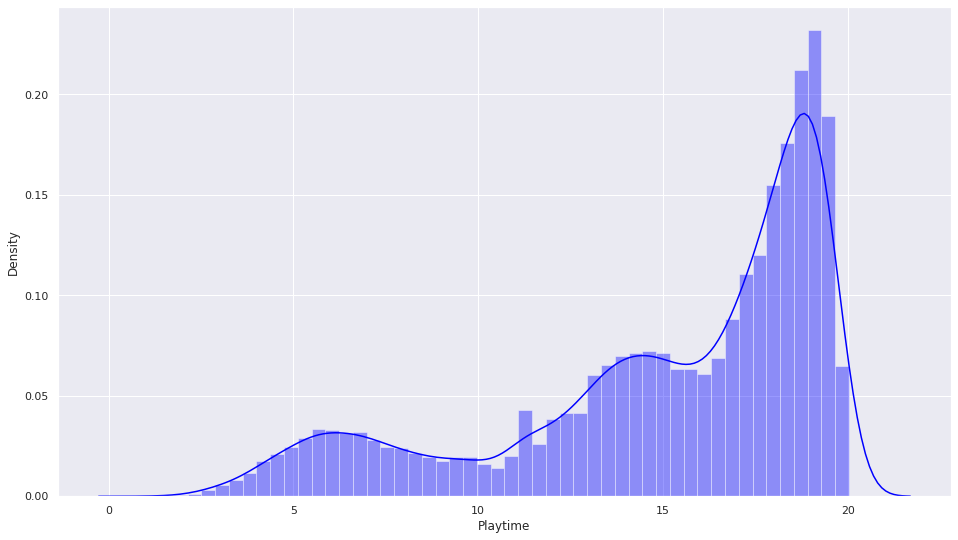

In [ ]:
sns.distplot(train[target], color="blue")

In [ ]:
df[df['Odds'] != 0].shape

(13318, 6)

# 가설 검증

## 1. 평균 게임시간이 길수록 승률이 높을 것이다.

In [ ]:
import scipy.stats as stats
na_table = pd.crosstab(index = train['Avg_Playtime'], columns = train['Odds'])

chi, p, _, _ = stats.chi2_contingency(na_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 126528480.56868549
p-value : 0.0


카이제곱검정을 통해서 두 변수간의 관계는 없다는 귀무가설은 기각된다. 

(p-value < 0.05)

즉, 두 변수 간의 관계는 있다.

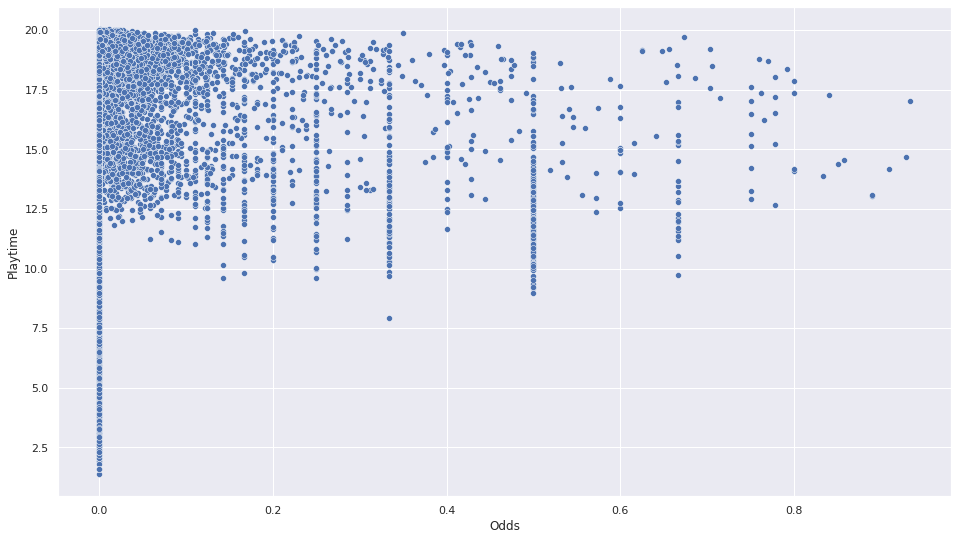

In [ ]:
sns.scatterplot(x=train['Odds'], y=train[target])

명확한 양의 상관관계는 보이지 않는다. 오히려 판수가 많아질수록 승률은 낮아지는 경향이 있다.

이는 승률 자체가 승리횟수 / 게임판수 라는 공식의 영향이 강하다고 보인다.

## 2. 게임을 플레이한 기간이 오래될수록 승률이 높을 것이다.

In [ ]:
na_table = pd.crosstab(index = train['Games_Played'], columns = train[target])

chi, p, _, _ = stats.chi2_contingency(na_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

카이제곱 검정에서 p-value < 0.05

플레이 기간과 승률 간의 관계는 있다.

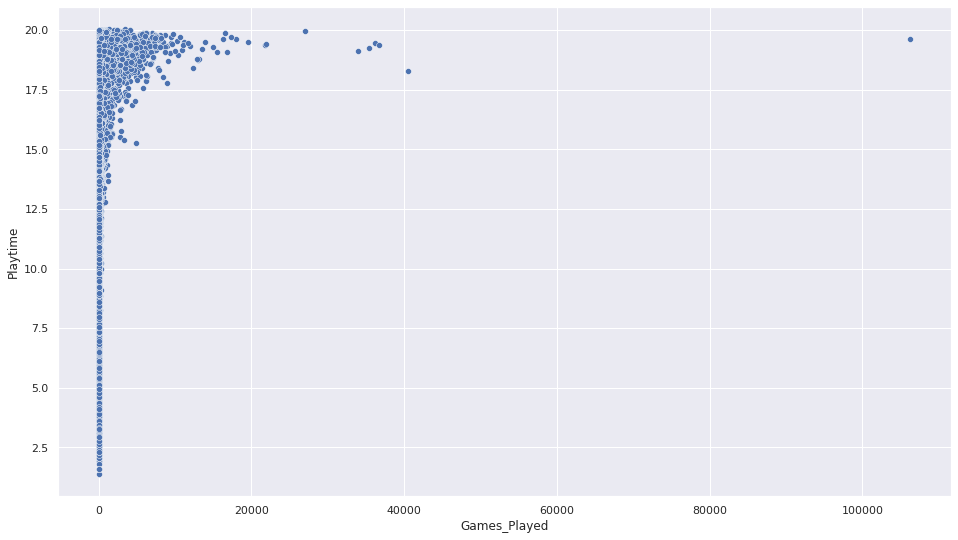

In [ ]:
sns.scatterplot(x=train['Games_Played'], y=train[target])

명확한 양의 관계는 보이지 않지만, 플레이타임이 어느정도 높아지는 시점부터 승률이 오른다는 것을 확인할 수 있다. 여기서 플레이타임은 로그변환이 된 것이므로, 뒤로 갈수록 훨씬 넓은 범위에 해당한다.

## 3. 평균 점수가 높을수록(매 판마다 더 잘할수록) 승률이 높을 것이다.

In [ ]:
na_table = pd.crosstab(index = train['Avg_Score'], columns = train['Odds'])

chi, p, _, _ = stats.chi2_contingency(na_table)
print('chi :', chi)    # chi : 18.099524243141698
print('p-value :', p)  # p-value : 0.0011800326671747886

chi : 118233331.784291
p-value : 0.0


카이제곱 검정 p-value < 0.05에 따라서 평균 점수와 승률은 관계가 있다.

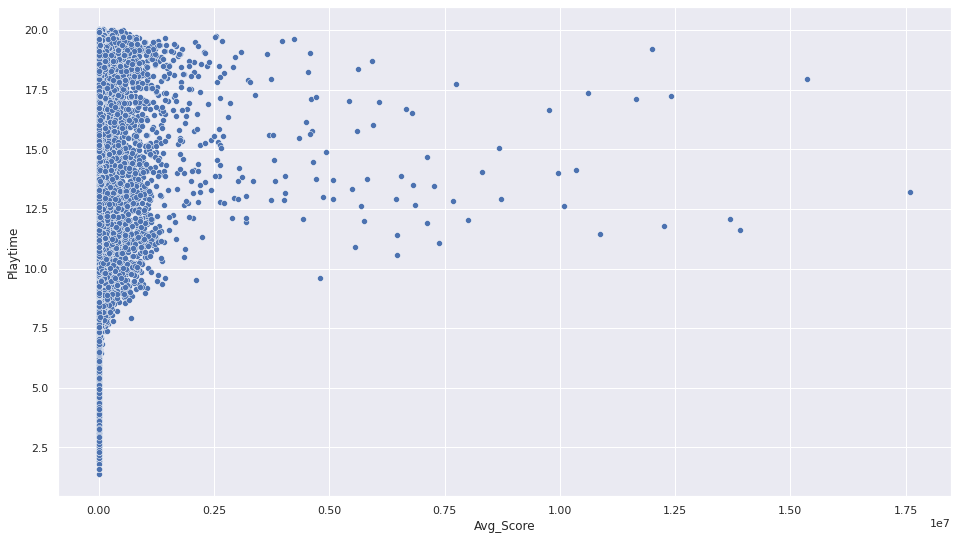

In [ ]:
sns.scatterplot(x=train['Avg_Score'], y=train[target])

평균점수가 높아질수록 승률이 오르는 것이 확인된다.

## 4. 최대 점수가 높을수록(잘해본 경험이 있다면) 승률이 높을 것이다.

In [ ]:
na_table = pd.crosstab(index = train['Best_Score'], columns = train['Odds'])

chi, p, _, _ = stats.chi2_contingency(na_table)
print('chi :', chi)   
print('p-value :', p)  

chi : 126424339.05151261
p-value : 0.0


p-value < 0.05 두 변수 관계 있음

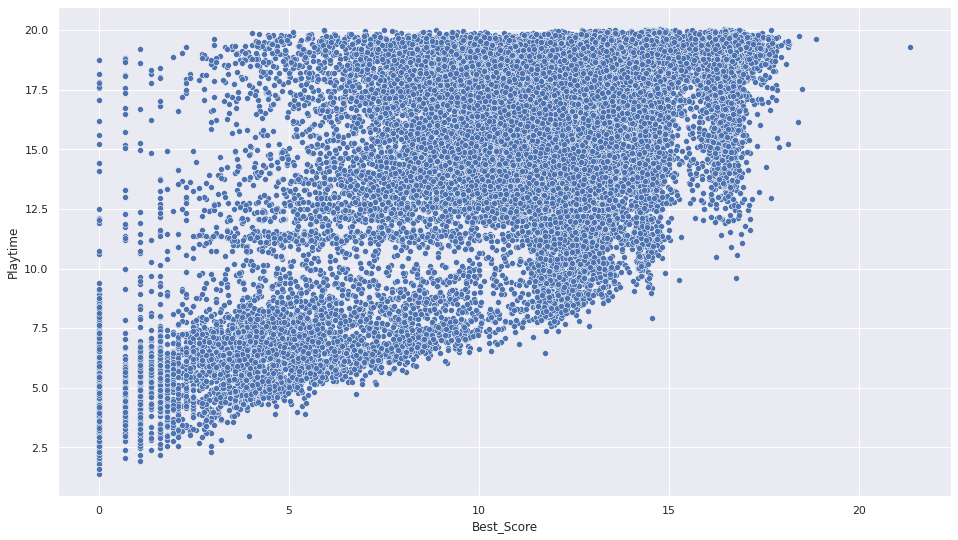

In [ ]:
sns.scatterplot(x=np.log1p(train['Best_Score']), y=train[target])

높은 점수대에서만 0%가 아닌 승률이 확인된다. 특정 점수부터 승리할 수 있기 때문이라고 판단한다.

In [ ]:
df[df['Odds'] == 0]['Best_Score'].sort_values()

33125          0
13527          0
13557          0
31559          0
45450          0
          ...   
19387    1879999
25136    1879999
41988    1879999
43471    1881058
15859    1888919
Name: Best_Score, Length: 40547, dtype: int64

# Model 학습 및 비교

## 1.XGBregressor모델과 Hyperopt를 활용한 하이퍼파라미터 튜닝

randomCV의 경우 시간이 너무 오래 걸리므로, 1회 시행 후 hyperopt로 세부 조정을 하는 것이 좋다고 생각한다.

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    print(f'Test mae : {test_mae:.2f}')

    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE scores:", test_rmse)

    test_r2 = r2_score(y_test, y_pred)
    print("R2 scores:", test_r2)
    return test_mae, test_rmse, test_r2

In [13]:
## 1. 검색 공간 설정

from hyperopt import hp

xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 1, 15, 1),                     ## 정수형 하이퍼 파라미터 => quniform 사용
    'min_child_weight':hp.quniform('min_child_weight', 1, 4, 1),        ## 정수형 하이퍼 파라미터 => quniform 사용
    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 20, 1),
    'n_estimators': hp.quniform('n_estimators', 600, 1000, 10)
}

In [16]:
## 2. 목적 함수 설정
## 검색 공간에서 설정한 하이퍼 파라미터들을 입력 받아서 XGBoost를 학습시키고, 평가 지표를 반환하도록 구성되어야 함

from sklearn.model_selection import cross_val_score  ## 교차 검증
from xgboost import XGBRegressor
from hyperopt import STATUS_OK

def objective_func(search_space):

  model = XGBRegressor(
      n_estimators=int(search_space['n_estimators']),
      max_depth=int(search_space['max_depth']),                ## int형으로 형변환 필요
      min_child_weight=int(search_space['min_child_weight']),  ## int형으로 형변환 필요
      learning_rate=search_space['learning_rate'], 
      colsample_bytree=search_space['colsample_bytree'],
      scale_pos_weight=int(search_space['scale_pos_weight']),
      eval_metric='rmse',
      objective='reg:squarederror'
  )

  evaluation = [(X_train, y_train), (X_val, y_val)]

  model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

  pred = model.predict(X_val)
  rmse = mean_squared_error(y_val, pred, squared=False)
  ####
  best_score = cross_val_score(model, X_train, y_train, 
                                 scoring='neg_mean_absolute_error', 
                                 cv=3, 
                                 n_jobs=8).mean()
  loss = -1*best_score
  #####
  print("loss :", loss)
  print("RMSE scores:", rmse)

  ## scores는 cv=5 개수만큼의 결과를 리스트로 가짐, 이를 평균하여 반환하되, -1을 곱함
  return {
      'loss':loss,
      'status':STATUS_OK,
      'model': model
  }

In [17]:
## 3. fmin()을 사용하여 최적 하이퍼 파라미터 찾기

from hyperopt import fmin, tpe, Trials

trials = Trials() ## 결과 저장

best = fmin(
    fn=objective_func,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=50,    ## 최대 반복 횟수 지정
    trials=trials,
)
best ## 정수형 하이퍼 파라미터 값이 뒤에 .0이 붙어서 실수형으로 반환됨을 유의하기!

loss :
1.7257815088984774
RMSE scores:
2.2302541483528726
loss :
1.6772795294192875
RMSE scores:
2.193176690070136
loss :
1.7612749705422301
RMSE scores:
2.2454890643883854
loss :
1.7859005161405077
RMSE scores:
2.21133834934643
loss :
1.7661410467722007
RMSE scores:
2.234886827570105
loss :
1.6766534220169984
RMSE scores:
2.1874114249361507
loss :
1.6943541320899682
RMSE scores:
2.1874958797778006
loss :
1.7535553895437503
RMSE scores:
2.2419510218898075
loss :
1.6699812082014651
RMSE scores:
2.187907043690464
loss :
1.7431354999074842
RMSE scores:
2.1973352094331786
loss :
1.7483203876413749
RMSE scores:
2.19716520654501
loss :
1.7156375206816994
RMSE scores:
2.19779002452177
loss :
1.7997374919166191
RMSE scores:
2.2163970619595186
loss :
1.7246320998419982
RMSE scores:
2.2111684590730993
loss :
1.761055347200913
RMSE scores:
2.212337138833724
loss :
1.6837586116505374
RMSE scores:
2.18724238545908
loss :
1.6670676805847802
RMSE scores:
2.187693501843783
loss :
1.709689858474871
RMS

{'colsample_bytree': 0.8085533354561016,
 'learning_rate': 0.03138082633496567,
 'max_depth': 2.0,
 'min_child_weight': 4.0,
 'n_estimators': 810.0,
 'scale_pos_weight': 12.0}

In [ ]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(colsample_bytree=0.9779400985013907, eval_metric='rmse',
             learning_rate=0.0987989866505573, max_depth=5, min_child_weight=3,
             n_estimators=820, objective='reg:squarederror',
             scale_pos_weight=10)


In [ ]:
xgb_preds_best = best_model.predict(X_val)
xgb_score_best = mean_squared_error(y_val, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

xgb_standard = XGBRegressor().fit(X_train, y_train)
standard_score = mean_squared_error(y_val, xgb_standard.predict(X_val), squared=False)
print('RMSE_Standard_Model:', standard_score)

RMSE_Best_Model: 81823535.68443434
[14:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE_Standard_Model: 81846026.50831373


### 로그 변환 이후

In [ ]:
## 1. 검색 공간 설정

from hyperopt import hp

xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 1, 15, 1),                     ## 정수형 하이퍼 파라미터 => quniform 사용
    'min_child_weight':hp.quniform('min_child_weight', 1, 4, 1),        ## 정수형 하이퍼 파라미터 => quniform 사용
    'eta': hp.uniform('eta', 0.8,1),
    'n_estimators': hp.quniform('n_estimators', 600, 1000, 10)
}

In [ ]:
## 2. 목적 함수 설정
## 검색 공간에서 설정한 하이퍼 파라미터들을 입력 받아서 XGBoost를 학습시키고, 평가 지표를 반환하도록 구성되어야 함
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score  ## 교차 검증
from xgboost import XGBRegressor
from hyperopt import STATUS_OK

def objective_func(search_space):

  model = XGBRegressor(
      n_estimators=int(search_space['n_estimators']),
      max_depth=int(search_space['max_depth']),                ## int형으로 형변환 필요
      min_child_weight=int(search_space['min_child_weight']),  ## int형으로 형변환 필요
      learning_rate=0.174,
      colsample_bytree=0.87,
      eta=search_space['eta'],
      scale_pos_weight=13,
      eval_metric='rmse',
      objective='reg:squarederror'
  )

  evaluation = [(X_train, y_train), (X_val, y_val)]

  model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

  pred = model.predict(X_val)
  rmse = mean_squared_error(y_val, pred, squared=False)

  print("RMSE scores:", rmse)

  ## scores는 cv=5 개수만큼의 결과를 리스트로 가짐, 이를 평균하여 반환하되, -1을 곱함
  return {
      'loss':rmse,
      'status':STATUS_OK,
      'model': model
  }

In [ ]:
## 3. fmin()을 사용하여 최적 하이퍼 파라미터 찾기

from hyperopt import fmin, tpe, Trials

trials = Trials() ## 결과 저장

best = fmin(
    fn=objective_func,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=50,    ## 최대 반복 횟수 지정
    trials=trials,
)
best ## 정수형 하이퍼 파라미터 값이 뒤에 .0이 붙어서 실수형으로 반환됨을 유의하기!

RMSE scores:
0.020736070712431377
RMSE scores:
0.021236260290791516
RMSE scores:
0.022930688303661823
RMSE scores:
0.020996095615778067
RMSE scores:
0.022408687852136375
RMSE scores:
0.020363667423973497
RMSE scores:
0.02257848426141088
RMSE scores:
0.02189008363472716
RMSE scores:
0.023349935046088784
RMSE scores:
0.022717305439349918
RMSE scores:
0.022930688303661823
RMSE scores:
0.023097816011368257
RMSE scores:
0.023446564283366153
RMSE scores:
0.02244868767361712
RMSE scores:
0.023097816011368257
RMSE scores:
0.0223585385519393
RMSE scores:
0.023097816011368257
RMSE scores:
0.02075437646105151
RMSE scores:
0.0210200185093248
RMSE scores:
0.022486028980387127
RMSE scores:
0.03546584294550438
RMSE scores:
0.020936985435710976
RMSE scores:
0.021989042839032857
RMSE scores:
0.021236260290791516
RMSE scores:
0.020645045915710848
RMSE scores:
0.020871693227073072
RMSE scores:
0.03555010734808995
RMSE scores:
0.021391649128532867
RMSE scores:
0.020363667423973497
RMSE scores:
0.021448741

{'eta': 0.8559494667115668,
 'max_depth': 5.0,
 'min_child_weight': 2.0,
 'n_estimators': 670.0}

In [ ]:
from sklearn.metrics import f1_score
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']

xgb_preds_best = best_model.predict(X_val)

test_mae = mean_absolute_error(y_val, xgb_preds_best)
print(f'Test mae : {test_mae:.2f}')

xgb_score_best = mean_squared_error(y_val, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

xgb_standard = XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)
standard_score = mean_squared_error(y_val, xgb_standard.predict(X_val), squared=False)
print('RMSE_Standard_Model:', standard_score)


Test mae : 0.00
RMSE_Best_Model: 0.020363667423973497
RMSE_Standard_Model: 0.022043429662887096


최종모델

In [18]:
model = XGBRegressor( 
      n_estimators=810,
      max_depth=2,                ## int형으로 형변환 필요
      min_child_weight=4,  ## int형으로 형변환 필요
      learning_rate=0.03138082633496567, 
      colsample_bytree=0.8085533354561016,
      scale_pos_weight=12,
      eval_metric='rmse'
  )

model.fit(X_train, y_train)

[01:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8085533354561016, eval_metric='rmse',
             learning_rate=0.03138082633496567, max_depth=2, min_child_weight=4,
             n_estimators=810, scale_pos_weight=12)

In [19]:
test_mae, test_rmse, test_r2 = calculate_score(model, X_val, y_val)

Test mae : 1.67
RMSE scores: 2.189283320395807
R2 scores: 0.7609775065628036


In [ ]:
round(-1.5136087854639158e-05,3)

-0.0

## 2.학습된 모델로부터 feature importance

In [ ]:
import numpy as np


def get_feature_importances(model, feature_names):
    feature_importances = np.zeros(len(feature_names))

    feature_importances = pd.Series(model.feature_importances_, feature_names)

    return sorted(
        list(zip(feature_names, feature_importances)), key=lambda x: x[1], reverse=True
    )

In [ ]:
feature_importances = get_feature_importances(
    best_model, list(X_train.columns)
)

In [ ]:
for name, importance in feature_importances:
    print(f"{name}: {importance:.4f}")

Games_Played: 0.6759
Total_score: 0.1498
Odds: 0.0674
Avg_Score: 0.0548
Best_Score: 0.0521


## 3 본인이 만든 모델의 Test 셋에서의 성능을 확인

In [20]:
test_mae, test_rmse, test_r2 = calculate_score(model, X_test, y_test)

Test mae : 1.66
RMSE scores: 2.2008419284111773
R2 scores: 0.7553094276124891


# XAI 과정

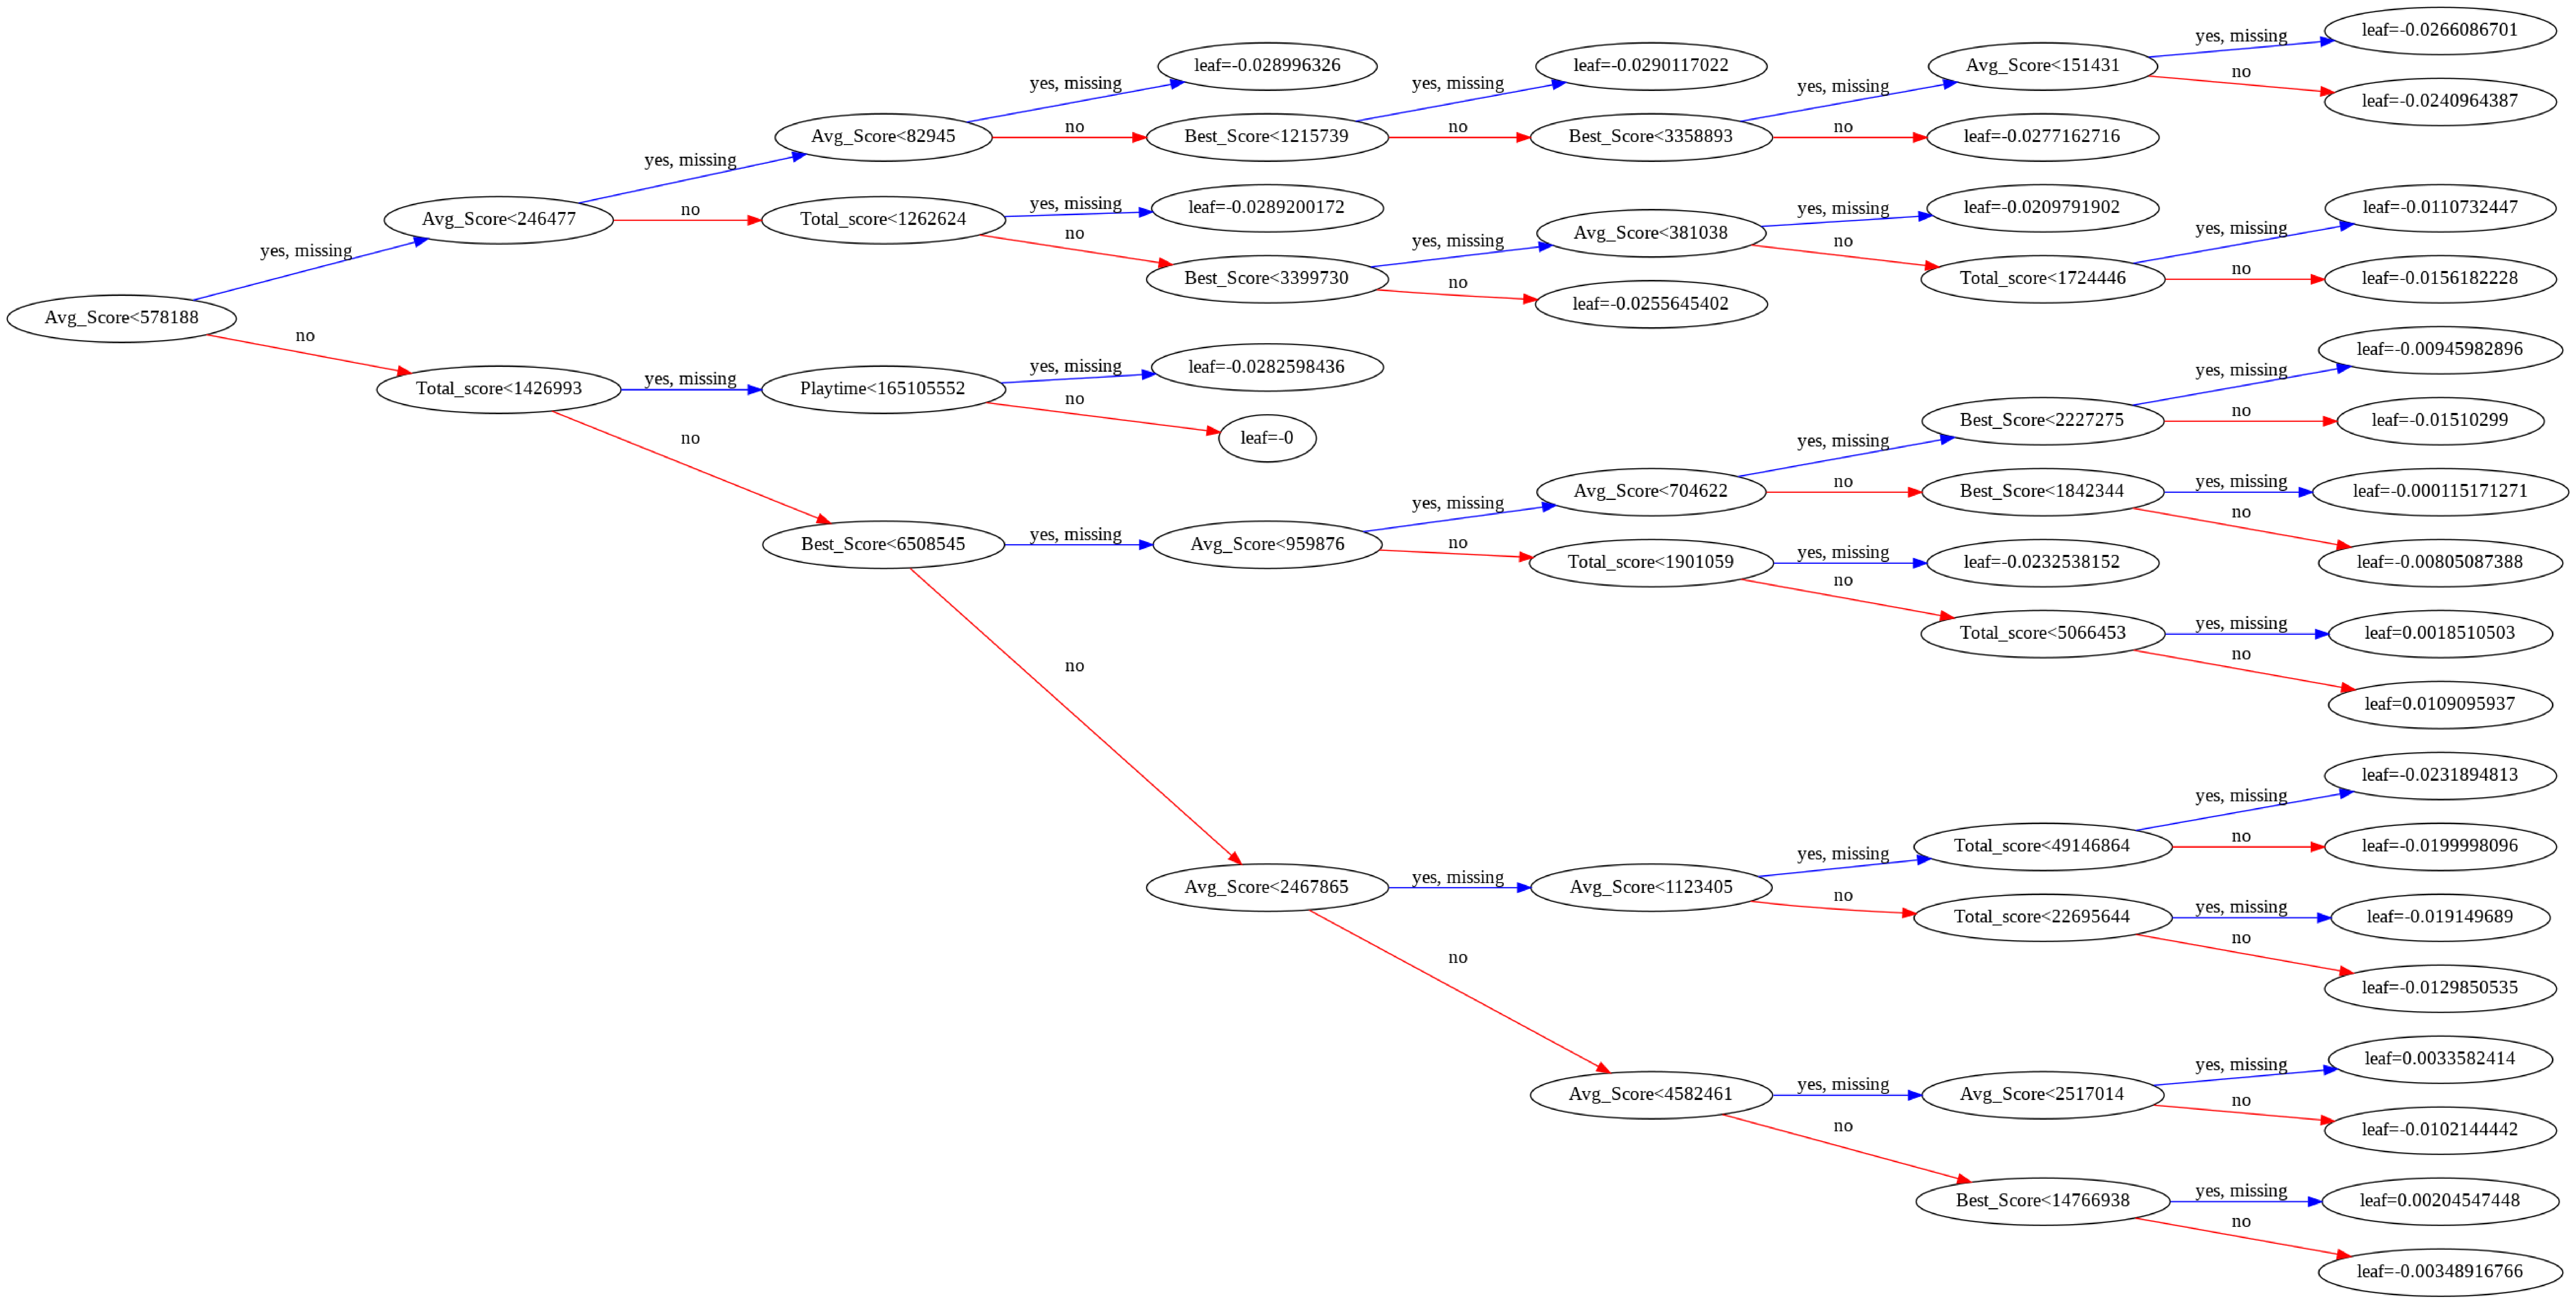

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

  # 이미지 저장하고 싶다면
  # fig.savefig('tree.png')

plt.show()

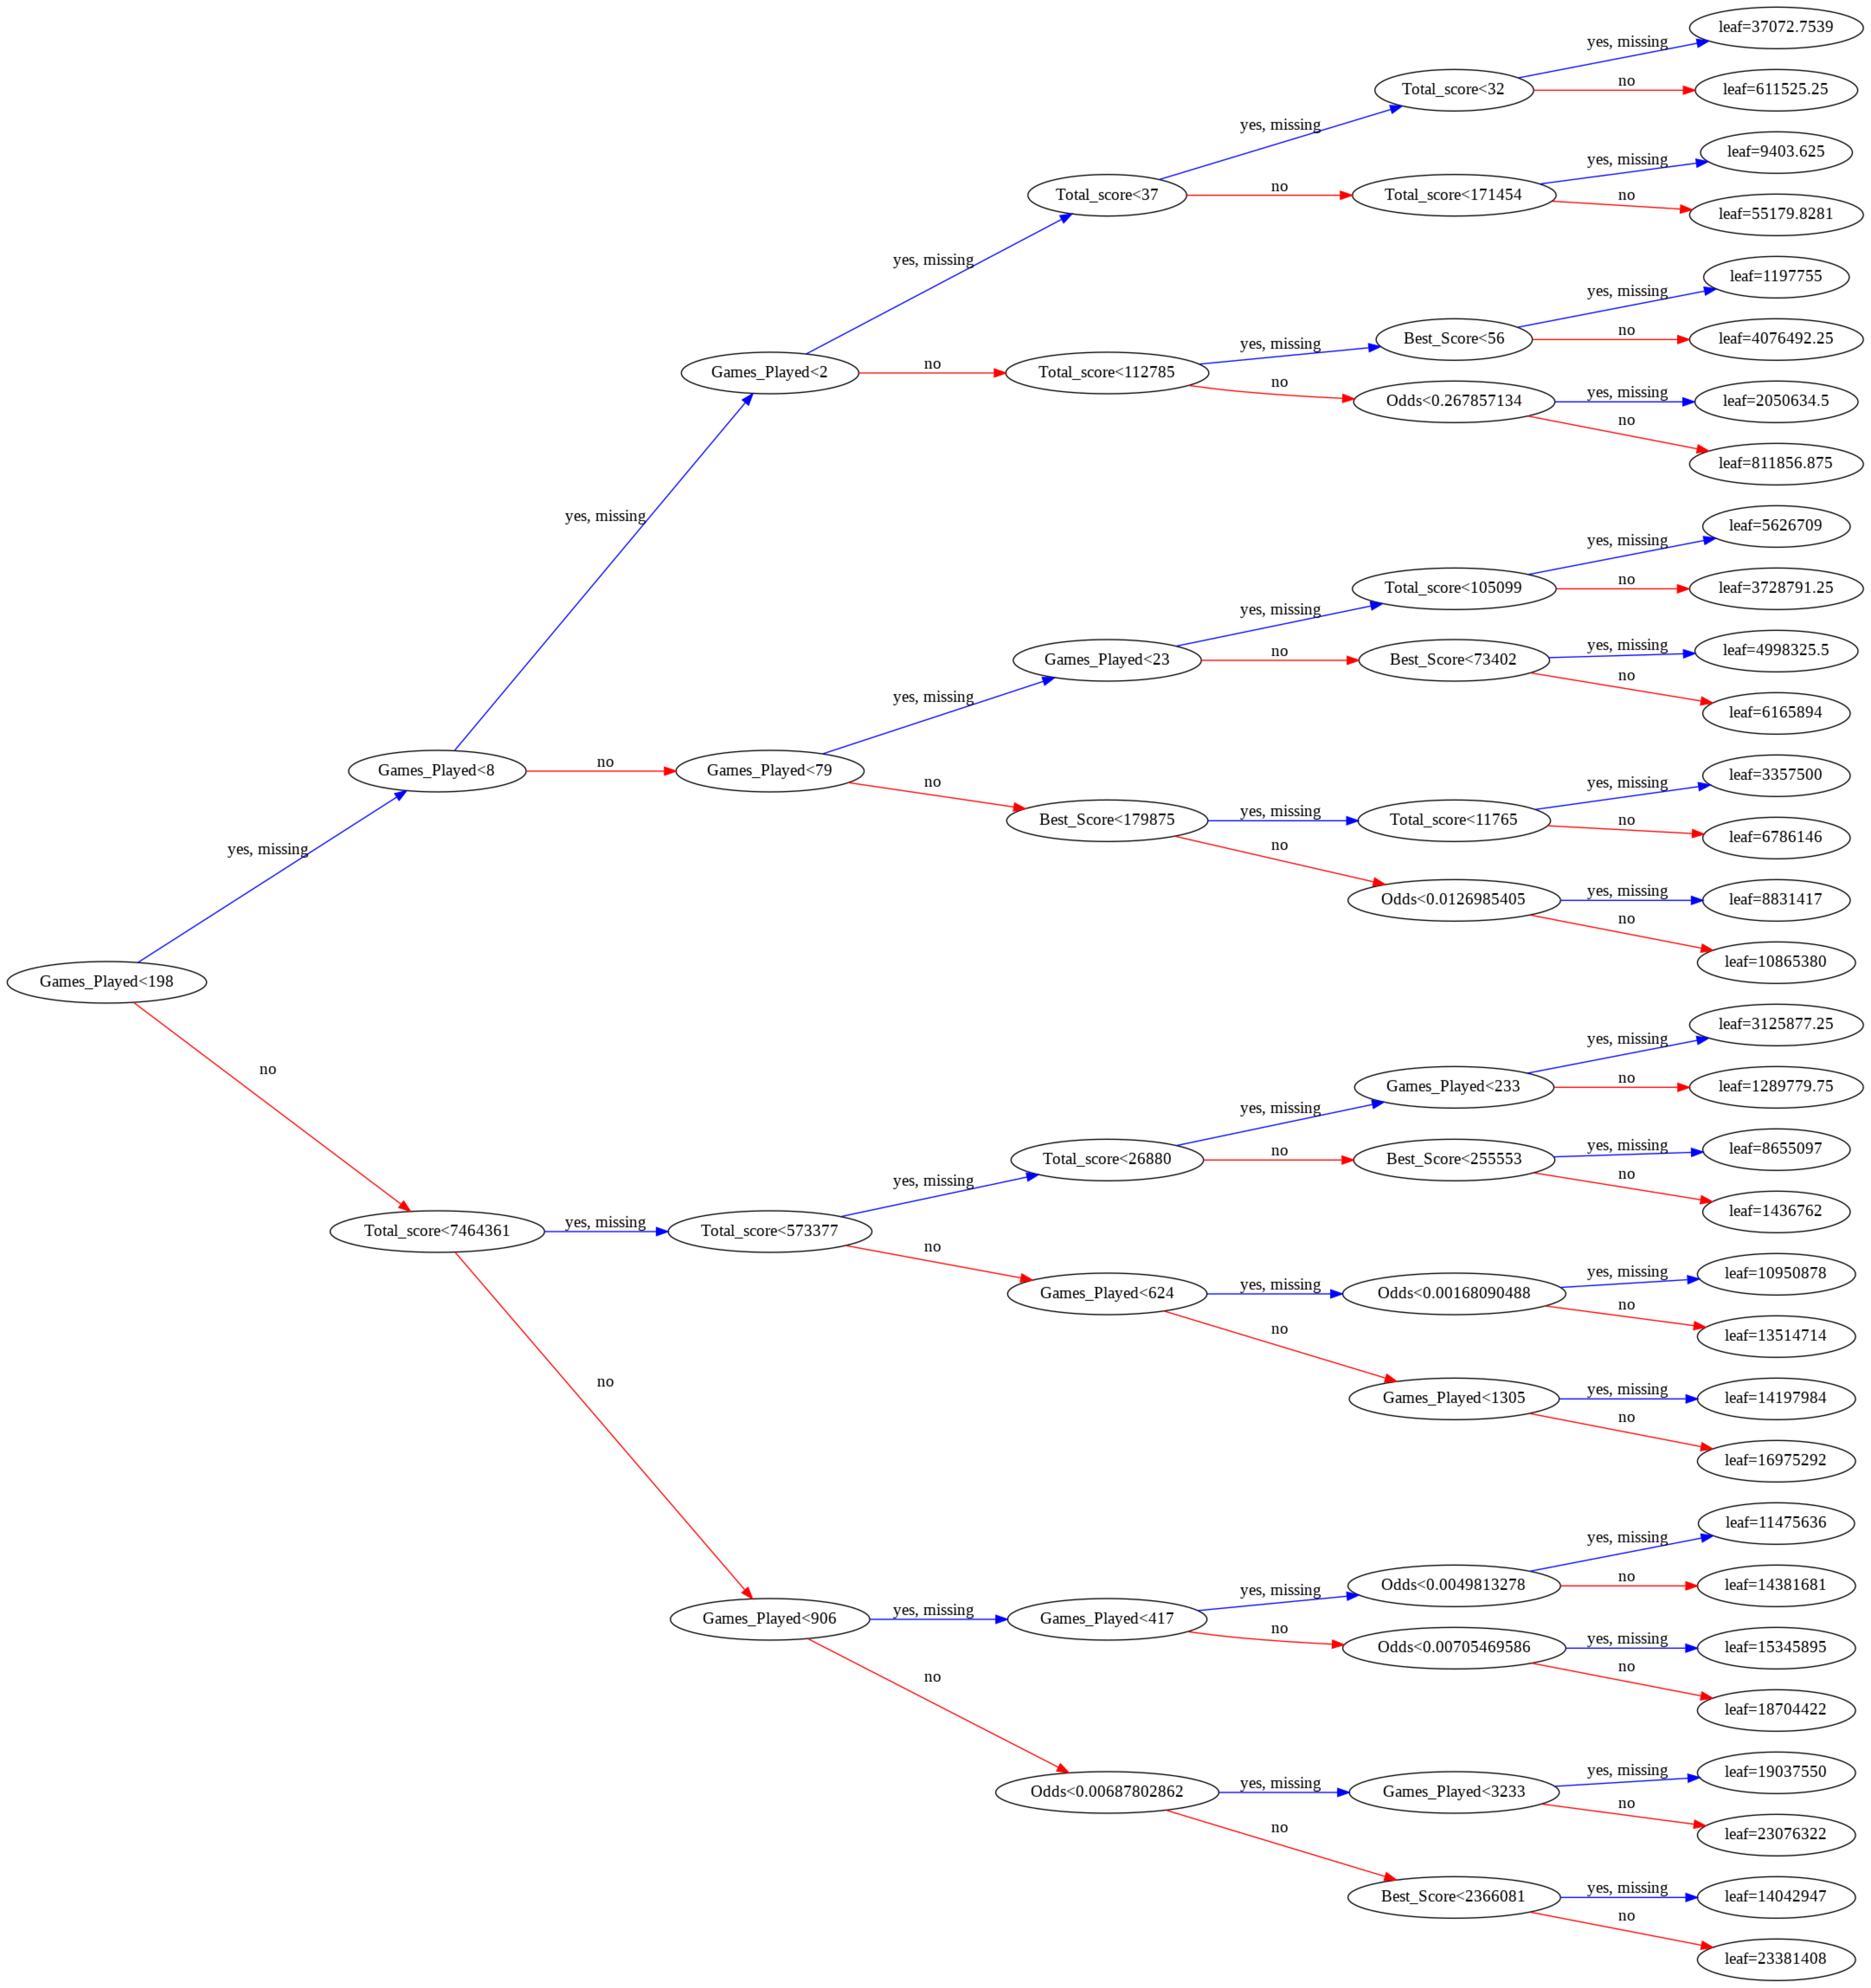

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

  # 이미지 저장하고 싶다면
  # fig.savefig('tree.png')

plt.show()

In [88]:
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 129 kB/s 
     |████████████████████████████████| 37.8 MB 248 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=98d2dbcf46b9f092ec186cc8d3c565b16122acd33b6a29fbb449c4f622d85898
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=11152138 sha256=2cf2048e3120e5c24fa18ba3ba60e8c23bd730ae1701195286435c1a511915c8
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=28422b1040ef5523e9234ed5f9235925a3c8705bdfe873f1e365f638c8c12368
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 6.6 MB/s 


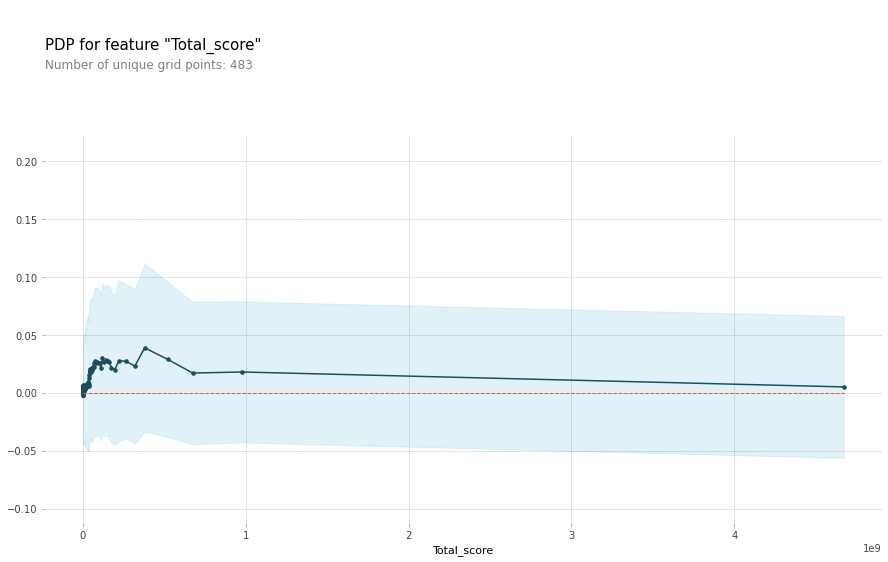

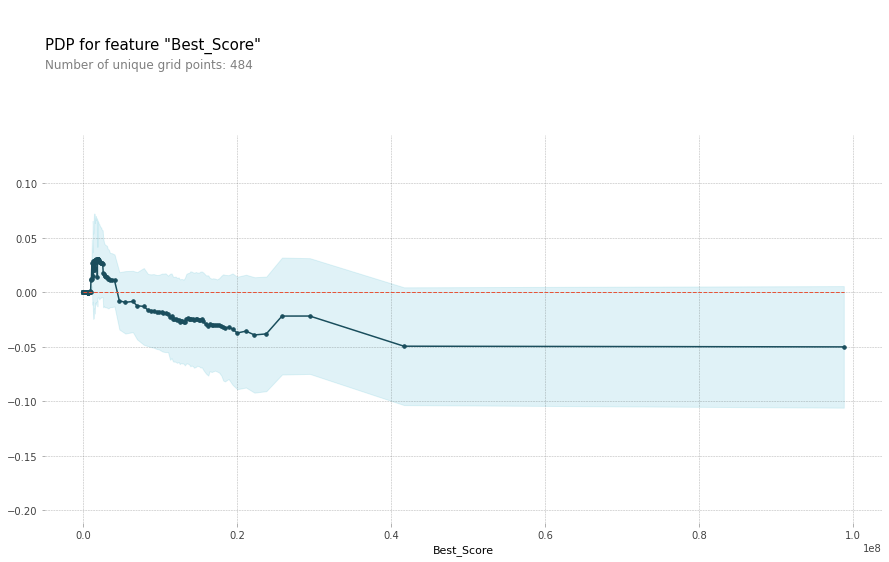

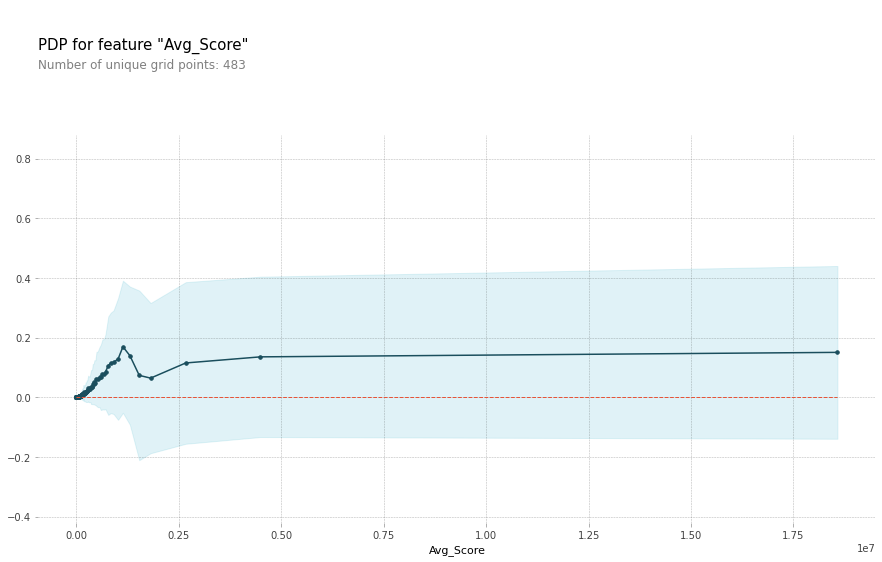

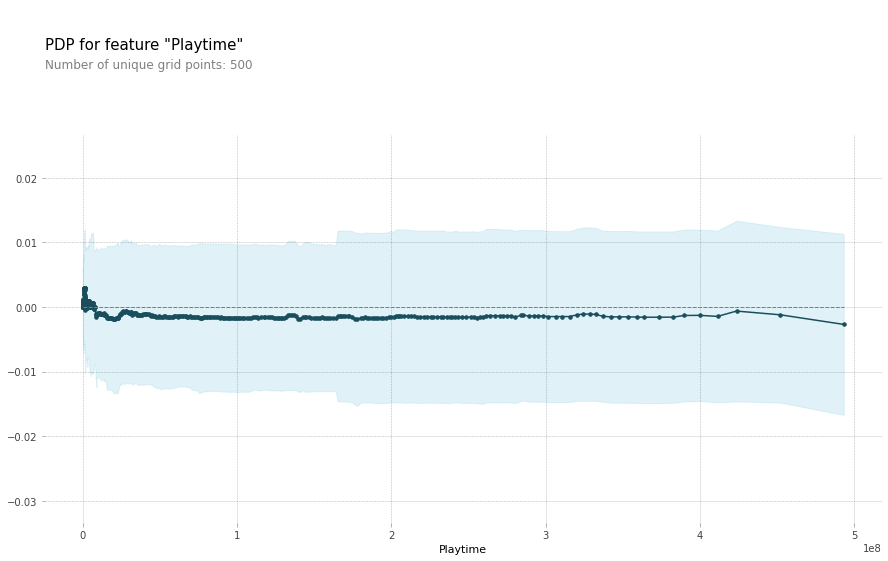

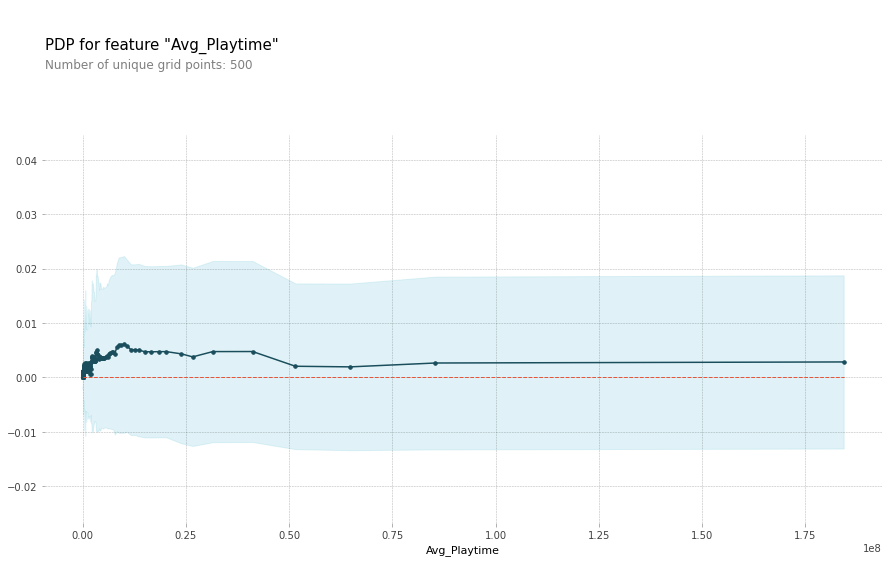

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for f in X_train.columns:
    isolated = pdp_isolate(
        model=model, 
        dataset=X_val, 
        model_features=X_val.columns, 
        feature=f,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=500 # default=10
    )
    pdp_plot(isolated, feature_name=f);

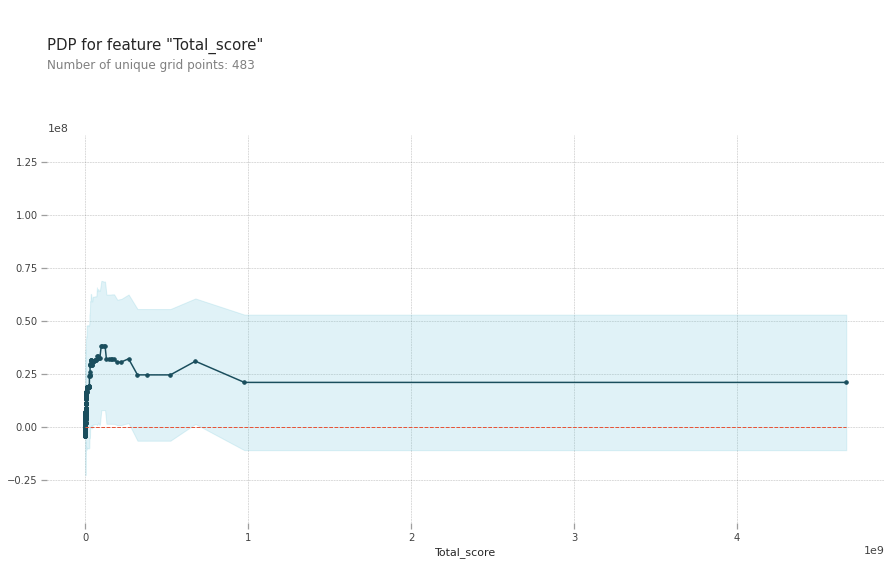

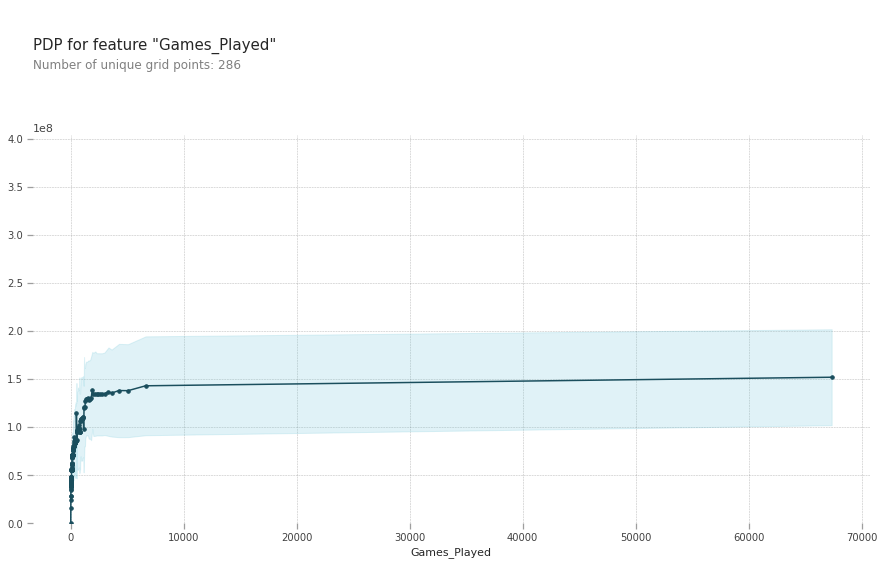

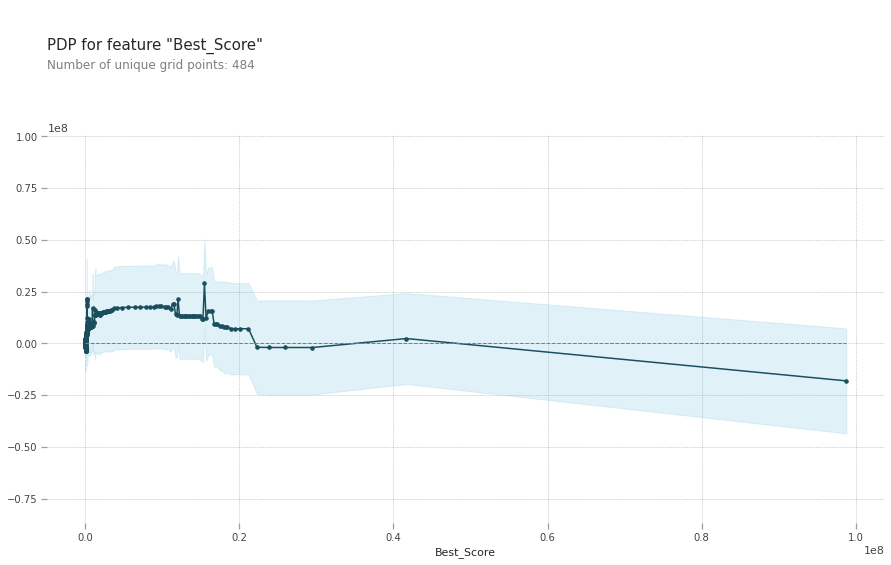

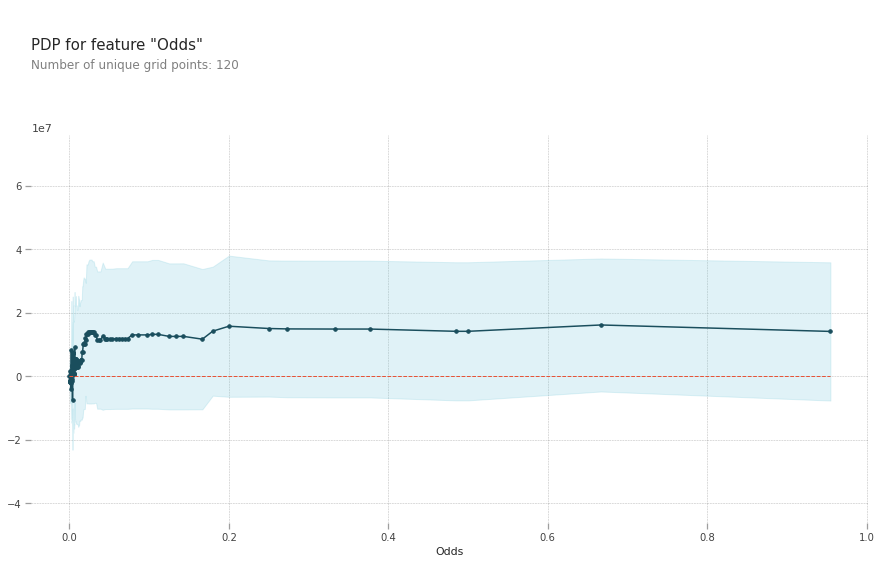

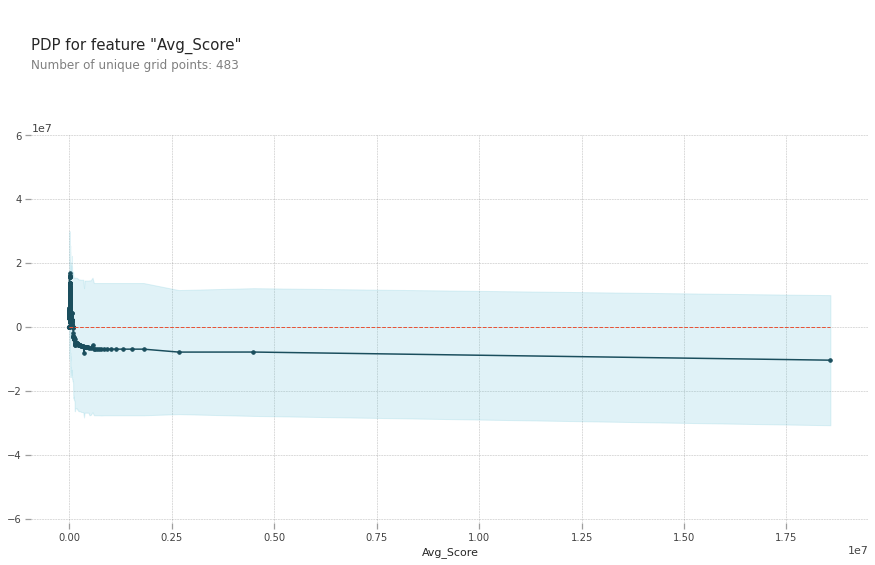

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for f in X_train.columns:
    isolated = pdp_isolate(
        model=best_model, 
        dataset=X_val, 
        model_features=X_val.columns, 
        feature=f,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=500 # default=10
    )
    pdp_plot(isolated, feature_name=f);

In [90]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)

In [93]:
def test_percent(col, per):
    test_df = pd.DataFrame(df.median()).T.drop(target,axis=1)
    test_df[col] = [np.percentile(df[col], per)]
    row = test_df.iloc[[0]]

    return row

모든 특성이 중간값이고, 승률이 약 1%일 경우

In [95]:
np.percentile(df['Odds'], 87.5)

0.012987012987012988

In [94]:
row = test_percent('Odds', 87.5)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [96]:
np.expm1(16.75)

18811895.11953723

이를 변환해주면

217일과 17시간31분35초가 나온다.

In [ ]:
def test_percent(col, per):
    test_df = pd.DataFrame(df.mean()).T.drop(target,axis=1)
    test_df[col] = [np.percentile(df[col], per)]
    row = test_df.iloc[[0]]

    return row

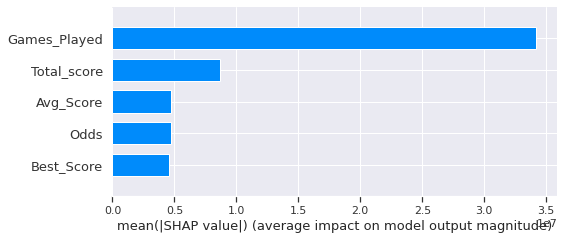

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:1000])
shap.summary_plot(shap_values, X_test.iloc[:1000], plot_type='bar')

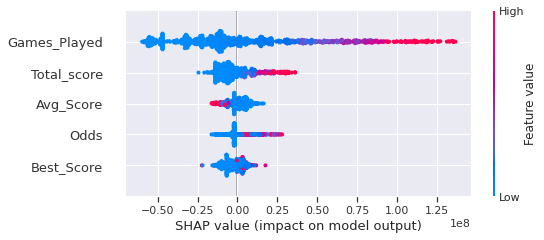

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:1000])
shap.summary_plot(shap_values, X_test.iloc[:1000])

기존의 유저 데이터를 통하여 모델을 학습시키고, 승률을 예측하는 것은 큰 의미는 없다. 위의 특성이 주어졌을 경우 승률을 예측하는 것에 특별한 가치는 없기 때문이다.

하지만, 승률을 예측하기 위해서 필요한 특성과 그 범위를 확인하고 이에 따라서 해당 승률을 달성하기 위한 조건을 파악할 수 있었다.

모델의 오차는 굉장히 낮으며 따라서 승률과 특성에 대한 신뢰도는 상당히 높다.



부트샘플링을 통하여 표준 집단 5% ~ 95% 내의 특성을 가진 사람들이 승률이 1%가 고정될 경우 Playtime을 알아본다.

In [97]:
sample_df = pd.DataFrame(columns=df.columns)

for i in range(5, 95, 5):
    s = []
    for col in df.columns:
      if col == 'Odds':
        s.append(np.percentile(df['Odds'], 87.5))
        continue
      s.append(np.percentile(df[col], i))
    sample_df.loc[len(sample_df.index)] = s
    

In [98]:
sample_df.drop('Playtime', axis=1, inplace=True)

In [99]:
np.random.seed(67)
boot_df = pd.DataFrame()

for col in sample_df.columns:
    sample_of_10 = []
    for _ in range(10000):
      sample = np.random.choice(sample_df[col], 1, replace=True)
      sample_of_10.append(sample[0])
    boot_df[col] = sample_of_10

In [104]:
boot_df

Total_score  Games_Played  Best_Score      Odds  Avg_Score
0          7679.2          20.0   1337028.0  0.012987    10081.0
1        549329.4          12.0    119302.8  0.012987    10081.0
2         62945.8         113.0  10108096.6  0.012987    26848.0
3        169978.4         282.0  10108096.6  0.012987       53.0
4        364123.0         149.0      3132.8  0.012987    13945.4
...           ...           ...         ...       ...        ...
9995       7679.2          54.0        99.0  0.012987    13945.4
9996      62945.8          86.0    232406.6  0.012987    26848.0
9997   12672553.6          31.0    232406.6  0.012987   161125.8
9998     169978.4         113.0    509962.4  0.012987     3271.0
9999      62945.8           2.0      8930.0  0.012987    93140.8

[10000 rows x 5 columns]

In [100]:
boot_pred = model.predict(boot_df)

In [102]:
boot_pred.mean()

15.133743

In [103]:
np.expm1(15.133743)

3736809.5072609875

43일과 6시간0분9초